# CS146: Location Based Assignment

# Part 1: San Francisco Based Data Set

## Background

Since 1880, average global temperatures have increased by about 1 degrees Celsius (1.7° degrees Fahrenheit). Global temperature is projected to warm by about 1.5 degrees Celsius (2.7° degrees Fahrenheit) by 2050 and 2-4 degrees Celsius (3.6-7.2 degrees Fahrenheit) by 2100 (NCEI.Monitoring.Info@noaa.gov, n.d.). 

The Bay Area stands out due to the diverse range of climates that coexist within a relatively short distance. Even in San Francisco, which covers just 7 square miles, you can find microclimates within the city itself (San Francisco Weather: Why Is It so Cold?!!, n.d.).

This study aims to design models to understand the dynamics of temperature change in San Francisco, given its unique geographical position. 

# Data 

The data was scraped from the website https://www.wunderground.com/ and retrived from https://github.com/zonination/weather-us/blob/master/sanfrancisco.csv. 

The time range of the data is from 1948-01-01 to 2015-12-31. There are 24743 rows and 26 columns. Each row represents the daily measurement of the variables. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import arviz as az
import pytensor.tensor as pt

In [2]:
print('Upgrading PyMC to version 5. This takes about 50 seconds...')
!pip install --ignore-installed llvmlite > /dev/null 2> /dev/null
!pip install --upgrade "pymc>=5,<6" numexpr matplotlib numba > /dev/null 2> /dev/null

import pymc as pm
print(f"We're running PyMC v{pm.__version__} today.")

Upgrading PyMC to version 5. This takes about 50 seconds...
We're running PyMC v5.9.0 today.


In [3]:
np.random.seed(123)

In [4]:
file_path = "https://raw.githubusercontent.com/zonination/weather-us/master/sanfrancisco.csv"
df = pd.read_csv(file_path)
print(len(df))
df.head()

24743


,Unnamed: 0,Date,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,Mean.Humidity,...,Min.VisibilityMiles,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees.br...,city,season
0,1,1948-01-01,55,50.0,46.0,53.0,48.0,42.0,96.0,87.0,...,2.0,16.0,7.0,NaN,0.00,0.0,Fog-Rain,124<br />,San Francisco (CA),Winter
1,2,1948-01-02,57,55.0,53.0,56.0,53.0,51.0,93.0,91.0,...,3.0,22.0,11.0,NaN,0.00,0.0,Rain,202<br />,San Francisco (CA),Winter
2,3,1948-01-03,57,54.0,50.0,54.0,51.0,50.0,100.0,94.0,...,0.0,8.0,2.0,NaN,0.00,0.0,Fog,79<br />,San Francisco (CA),Winter
3,4,1948-01-04,59,57.0,55.0,55.0,54.0,54.0,97.0,91.0,...,3.0,18.0,7.0,NaN,0.00,0.0,Fog-Rain,191<br />,San Francisco (CA),Winter
4,5,1948-01-05,59,55.0,51.0,55.0,52.0,50.0,100.0,91.0,...,0.0,12.0,4.0,NaN,0.00,0.0,Fog,289<br />,San Francisco (CA),Winter


### Data modification

In the code cell above, we see the data set overview. We can see that the 'Date' column values correspond to daily measurements. In total, we have 24743 rows in the dataset. Most variables have the daily minimum, maximum and mean values of the measurements recorded. 

Since the data was recorded daily, the model might be biased by the daily fluctuations. To capture the general pattern more efficiently, I will group the data by month and calculate the mean for each group. It will help us gain a more comprehensive understanding of the overarching patterns in the data while reducing the impact of daily variability. 

As a result of this manipulation, I will get the dataset with the average monthly values, in total 814 rows each row representing a calendar month from from 1948-01 to 2015-12. I will also change the data column format to mm-yyyy to avoid redundancy. Additionally, I get rid of the NaN values and re-assign the index column.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#group by year and month and calculate the mean for each group
df_m = df.resample('M').mean()
df_m.reset_index(inplace=True)

#format the column to 'mm-yyyy' format
df_m['Date'] = df_m['Date'].dt.strftime('%m-%Y')
df_m.dropna(inplace=True)
df_m.reset_index(inplace=True)
df_m.head()

/var/folders/k_/yc0ykmqs4l725qknvzyg0mmc0000gn/T/ipykernel_89197/2825847531.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_m = df.resample('M').mean()


,index,Date,Unnamed: 0,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,...,Max.Sea.Level.PressureIn,Mean.Sea.Level.PressureIn,Min.Sea.Level.PressureIn,Max.VisibilityMiles,Mean.VisibilityMiles,Min.VisibilityMiles,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,CloudCover
0,299,12-1972,9141.0,49.612903,44.580645,39.580645,41.806452,37.483871,33.935484,89.354839,...,30.240000,30.180323,30.125806,13.032258,9.903226,7.645161,12.483871,6.419355,23.000000,0.000000
1,300,01-1973,9173.0,53.032258,47.548387,41.806452,46.032258,41.612903,35.709677,95.483871,...,30.195484,30.115806,30.034516,15.483871,10.935484,6.193548,14.806452,7.709677,38.000000,3.903226
2,301,02-1973,9202.5,58.071429,52.250000,46.285714,50.750000,47.392857,41.285714,98.107143,...,30.088929,30.001071,29.910357,16.607143,10.964286,5.250000,15.750000,6.571429,30.571429,5.964286
3,302,03-1973,9232.0,56.870968,50.935484,44.677419,47.419355,43.129032,38.741935,91.677419,...,30.092581,30.027742,29.963548,17.419355,13.354839,8.612903,19.129032,10.129032,32.818182,4.516129
4,303,04-1973,9262.5,64.366667,56.133333,47.700000,48.700000,43.933333,38.833333,86.400000,...,30.118000,30.071667,30.025333,16.333333,12.933333,9.733333,20.233333,9.966667,30.692308,2.333333


In [6]:
row_stats = df_m.describe()
#transpose the result to have rows as columns
row_stats = row_stats.T
row_stats

,count,mean,std,min,25%,50%,75%,max
index,512.0,557.669922,149.387878,299.000000,428.750000,557.500000,687.250000,815.000000
Unnamed: 0,512.0,17001.094727,4521.629393,9141.000000,13100.375000,17029.750000,20896.125000,24795.000000
Max.TemperatureF,512.0,64.848628,6.506901,42.466667,59.050000,65.639247,70.266667,80.933333
Mean.TemperatureF,512.0,57.707700,5.412334,44.580645,53.196429,58.032258,62.298387,69.033333
Min.TemperatureF,512.0,50.433323,4.671156,38.709677,47.112903,50.655376,54.387097,61.000000
Max.Dew.PointF,512.0,51.592682,3.971030,39.161290,48.661290,51.836022,54.675000,61.066667
MeanDew.PointF,512.0,47.960782,4.493445,34.193548,44.628226,48.216667,51.455376,58.600000
Min.DewpointF,512.0,44.108540,5.359641,28.290323,39.948214,44.131183,48.208333,56.500000
Max.Humidity,512.0,89.340355,4.368346,74.966667,86.700000,89.442473,92.321717,99.064516
Mean.Humidity,512.0,73.816198,5.371287,59.533333,70.225806,73.548387,77.330645,91.677419


### Variables 

The variables under study are "Mean.TemperatureF," which represents the average monthly temperature in Fahrenheit, and the row index, which is utilized as a time variable. Average temperature is a quantitative continuous variable that helps capture small variations. The row index is a quantitative discrete variable since it represents the equal time splits.  

In this context, each row corresponds to the following month chronologically. Time will be an independent variable, graphically represented on the x-axis, while the mean temperature will be considered the dependent variable, depicted on the y-axis. This arrangement allows for an exploration of how mean temperature varies over time.

In [7]:
temperature = df_m['Mean.TemperatureF']
index = df_m['index']

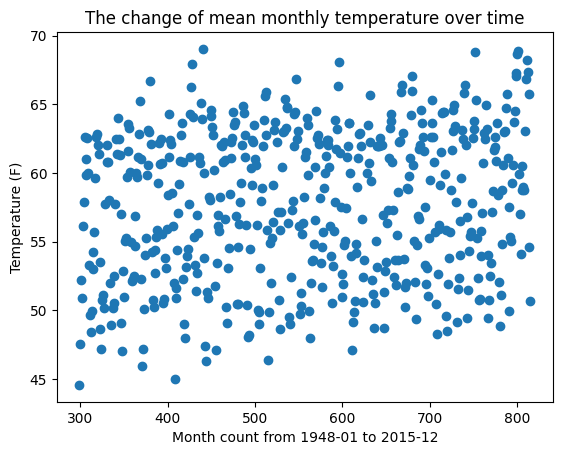

In [8]:
plt.scatter(index, temperature) 
plt.title('The change of mean monthly temperature over time')
plt.ylabel('Temperature (F)')
plt.xlabel('Month count from 1948-01 to 2015-12')
plt.show()

In [9]:
print('the range of y-values is', round(min(df_m['Mean.TemperatureF']),2), round(max(df_m['Mean.TemperatureF']),2))

the range of y-values is 44.58 69.03


# Part 2: Model the data 

In this part of the assignment, I will create 3 models to model the average temperature change with time. All models will be linear regression modeling. Using polynomial regression will not be efficient, given the linear trend of the data observed from the visualization. 

For the first model, I will use a Normal likelihood function. For the second model, I will use a Student T likelihood function. For the third model, I will fit the outlier detection function. All these distributions treat outliers differently, enabling us to see how outliers affect the regression.

From the visual inspection of the data, I can see no strong outliers. Also, outliers are not typical for the temperature data, especially in San Francisco. Therefore, I do not expect outliers to influence the distribution. Consequently, I expect the results of the models to be close to each other.  

### Model 1: Normal Likelihood Function  

Likelihood describes the data generation process. We assume that the errors in the relationship between the average monthly temperature and time are normally distributed. This suggests that as we move away from the regression line in both directions along the y-axis, outliers become increasingly rare. Normal likelihood is one of the most commonly used distributions for this type of model. It is reasonably robust to deviations from normality. This means that even if the underlying distribution of the data is not exactly normal, the normal likelihood can still provide meaningful estimates. Another benefit of using this function is that according to the Central Limit Theorem, the sum or average of a large number of independent and identically distributed random variables tends to follow a normal distribution. This makes the normal distribution convenient for modeling uncertainty and errors.

The parameters of the normal distribution are mean (mu) and standard deviation (q)

"q" is the standard deviation of the normal distribution. It will define the variability of the data. We model the average monthly temperature data in San Francisco, which is known for the low variability of its weather. For this reason, I would want to favor the smaller standard deviations over the bigger ones. Also, this parameter has a constraint that it cannot be negative. Therefore, I will use the HalfNormal distribution, which represents the positive values of the normal distribution centered at x = 0. The standard deviation is set to 20, which is a realistic assumption about the weather variability in San Francisco from my experience of living here for 2 semesters. 

"mu" is the mean of the normal distribution. It is deterministic, which means that it is calculated based on the values of other parameters in the model rather than estimated. It takes the x-value as input and, based on the values of "c0" and "c1" (model parameters for the intercept and slope), calculates the corresponding y-value, building the regression line. We use a normal distribution for the data generation process; "mu" determines the center of that normal distribution, while standard deviation determines the spread of the data.
 
"c0" is the intercept with the y-axis. I do not have any previous data to make an educated guess about which values are more likely to be the intercept. However, it is likely to be relatively close to the range of y-values, which is 
[44.58, 69.03] Therefore, I will use a uniform distribution where all the values have the same probability to avoid bias. I will set the lower bound as 0 and the upper limit at 100 to explore a wide range of values but to account for the range of the y values of the data. 

"c1" is the slope of the line. We have the data from multiple studies that the average temperature worldwide is rising. It gives us a reason to assume that the monthly mean temperature in San Francisco will have a similar pattern and that there is either a neutral or at least some positive relationship between the variables. Therefore, I want to have either a neutral or positive slope. We also know that although the temperature is increasing, its rate is not very fast, so we set the standard deviation to 5, which is a realistic value for this scenario.   

Since we have the data from multiple studies that the average temperature worldwide is rising, it gives us a reason to assume that the monthly mean temperature in San Francisco will have a similar pattern, so we assume that the probability of having a positive slope will be higher than the probability of having a negative relationship between the monthly mean temperature and time. 

\begin{align*}
\text{Likelihood:} \\
y_i &\sim \text{Normal}(u_i, q^2) \\
u_i &= c_0 + c_1x_i \\ \\
\text{Prior:} \\
c_0 &\sim \text{Uniform}(0, 100) \\
c_1 &\sim \text{Normal}(0, 5^2) \\
q &\sim \text{HalfNormal}(20^2)
\end{align*}

In the code, standard deviation is used, while the mathematical notation commonly represents variance, the square of standard deviation. To align these notations, the square of the discussed standard deviation is computed, converting the standard deviation to its variance.

In [10]:
#code was adapted form pre class work session 4.2: Robust linear regression

with pm.Model() as normal_model:
    # Data
    x = pm.MutableData('x', index)
    y = pm.MutableData('y', temperature)
    
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=100)
    c1 = pm.Normal('c1', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=20) 
    
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    
    # Likelihood
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    #sample
    normal_inference = pm.sample()
    
    #calculate log likelihood for part 3 
    pm.compute_log_likelihood(normal_inference)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


### Rank Plot and Infrence Summary  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,54.518,0.919,52.828,56.248,0.025,0.018,1368.0,1347.0,1.0
c1,0.006,0.002,0.003,0.009,0.000,0.000,1377.0,1288.0,1.0
sigma,5.357,0.169,5.057,5.688,0.004,0.003,2110.0,1822.0,1.0


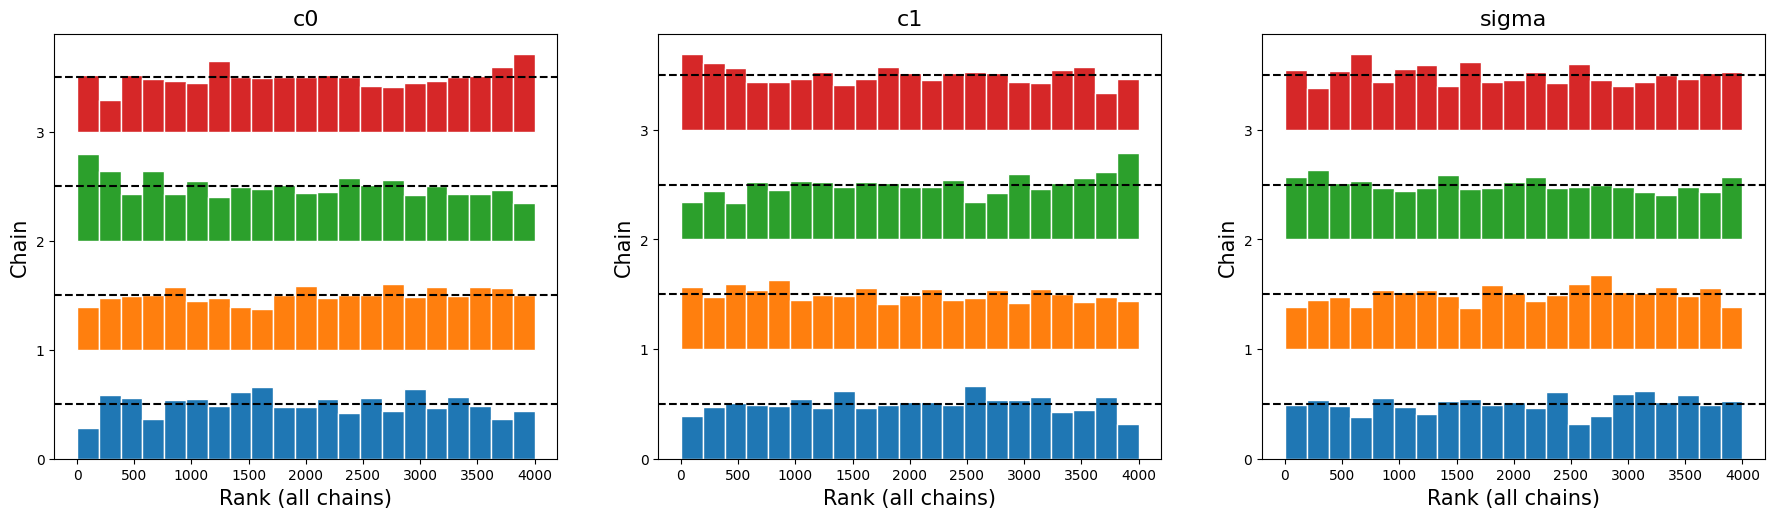

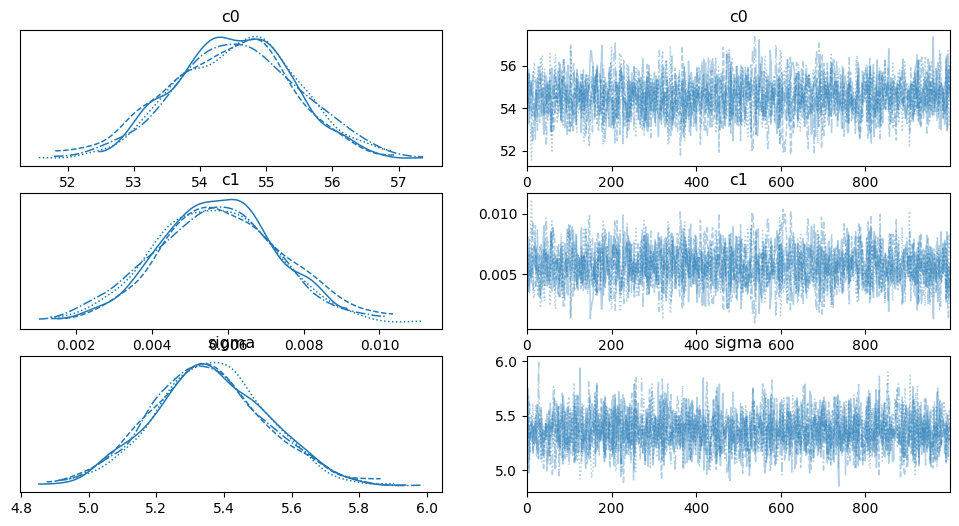

In [11]:
az.plot_rank(normal_inference, var_names=['c0', 'c1', 'sigma'])
az.plot_trace(normal_inference, var_names=['c0', 'c1', 'sigma'])
az.summary(normal_inference, var_names=['c0', 'c1', 'sigma'])

### Rank Plot and Inference Summary Analysis 

The goal of this analysis is to check if the sampler of the posterior distribution works correctly.\
We can evaluate the model's accuracy using the inference summary data.

r_hat is a metric of the efficiency of the convergence of MCMC chains. If the chains do not mix well or have not reached a stable distribution, the sample is unreliable since it does not represent the true posterior distribution. In this case, r_hat = 1 for all the estimated parameters. Therefore, the modeling results are reliable, the chains reached a stable distribution, and the results are not biased.

ESS is a metric that shows the number of independent samples, which is important to consider given that in MCMC, samples tend to be intercorrelated. We measure it in the center of the distribution (ess_bulk) and in the tails (ess_tail). ESS should be at least 10% of the sample. I will take the smaller of the 2 ESS measurements and verify if that assumption holds for all variables.

for c0 1524/4000 = 0.381 \
for c1 1526/4000 = 0.381 \
for sigma 1743/400 = 0.436 

All of the values are high above the 10% threshold, which reflects a high independence of the sample.
Rank plots show the distribution of the chains, which helps assess convergence. We aim at the same mean for each sample, resulting in a uniform distribution in a rank plot. Although the distribution is not perfectly flat for most of the chains, the samples are still balanced enough and close to the mean. Therefore, the sample works well, and chains converge.

We can also see the visualization of the convergence of the chins and the randomness of the sampling at the inference plots at the bottom. All values converged to the same distribution, and the chains mixed.

In [12]:
normal_inference.posterior

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, mu_dim_0: 512)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511
Data variables:
    c1        (chain, draw) float64 0.005515 0.005881 ... 0.005969 0.005756
    c0        (chain, draw) float64 54.22 54.86 54.19 ... 55.83 54.34 54.49
    sigma     (chain, draw) float64 5.542 5.756 5.687 ... 5.476 5.294 5.278
    mu        (chain, draw, mu_dim_0) float64 55.87 55.88 55.88 ... 59.17 59.18
Attributes:
    created_at:                 2023-10-19T05:11:39.062349
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              15.689649820327759
    tuning_steps:               1000

### Credible Intervals 

In [13]:
with normal_model:
    posterior_pred = pm.sample_posterior_predictive(normal_inference)

Sampling: [likelihood]


In [14]:
predicted_mu = normal_inference.posterior["mu"]
predicted_data = posterior_pred.posterior_predictive["likelihood"]

In [15]:
correlation_coefficient = df_m['Mean.TemperatureF'].corr(df_m['index'])
mean_y = df_m['Mean.TemperatureF'].mean()
mean_x = df_m['index'].mean()

# Calculate the slope and intercept of the true data
c1 = correlation_coefficient * (df_m['Mean.TemperatureF'].std() / df_m['index'].std())
c0 = mean_y - c1 * mean_x
predicted_y = c0 + c1 * df_m['index']


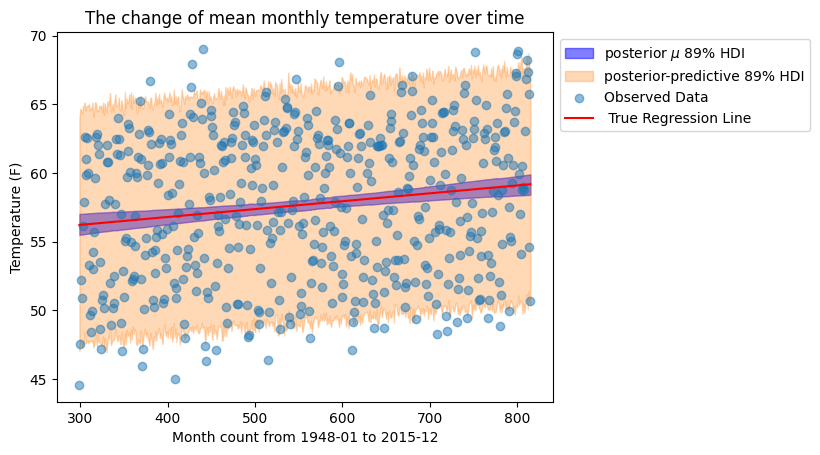

In [16]:
ax = az.plot_hdi(index, predicted_mu, color = 'b', smooth=False, hdi_prob=0.89,
                fill_kwargs={'alpha': 0.5, 'label': 'posterior $\mu$ 89% HDI'}) #label 89% HDI for the true data 
az.plot_hdi(index, predicted_data, ax=ax, smooth=False, hdi_prob=0.89,
            fill_kwargs={'alpha': 0.3, 'label': 'posterior-predictive 89% HDI'}) #89% HDI for the regression mean 

plt.scatter(index, temperature, alpha=0.5, label='Observed Data')
plt.plot(index, predicted_y, color='red', label=' True Regression Line')

plt.title('The change of mean monthly temperature over time')
plt.ylabel('Temperature (F)')
plt.xlabel('Month count from 1948-01 to 2015-12')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Credible Interval Analysis  

The purple-shaded area is a credible interval constructed based on the posterior distribution. It reflects our updated beliefs about the parameter after observing data. It represents the 89% range of plausible values for the mean of the regression line based on the model and the data. 

The orange shaded area represents the 89% credible interval for the posterior predictive distribution, thus the replication of the data generating process. It shows the possible outcomes for the observed data, considering both the uncertainty in the parameters and the randomness of the data-generating process.

Based on the graph, we can see that the orange area covers most of the true data points, with the proportion approximating 89%. This means that the model was successful in recreating the data-generating process. 

I calculated the correlation coefficient and the intercept on the true data and plotted it. We can see that the true regression line is within the bounds (approximately in the middle) of the 89% HDI of the posterior distribution estimation. It is also a sign of a good model. 

### Model 2: Student T Likelihood Function 

Student T likelihood is used when there are outliers in the dataset, and we do not want to give those outliers enough power to change the model's output.

Student T distribution differs from the Normal distribution because it has heavier tails. Thus, it allows for a higher probability of observing outliers and is not affected by the outliers as much as the normal distribution. In the normal distribution, 99% of the data is within 3 standard deviations for the mean. Heavier tails in the T distribution allow for values further from the mean. The "heaviness" of the tails represents the *nu* parameter of the T distribution. The smaller the *nu* value, the heavier the distribution's tails. As the value of the *nu* parameter increases, the t distribution approaches normal distribution. T distribution with *nu* = 30 is equivalent to normal distribution.

Except for *nu*, all other parameters of the Student T distribution are the same as the Normal distribution. All the parameter values in the Student T distribution will be kept the same as for the Normal distribution to allow comparability between both. 

*nu* parameter cannot be negative, so 0 will be a lower bound. I also know that as it approaches 30, the t distribution gets closer to the normal distribution, so I set the upper bound as 30. 
*nu* will be defined using a half-normal distribution with std 30. 


\begin{align*}
\text{Likelihood:} \\
y_i &\sim \text{T}(v, u_i, q^2) \\
u_i &= c_0 + c_1x_i \\ \\
\text{Prior:} \\
c_0 &\sim \text{Uniform}(0, 100) \\
c_1 &\sim \text{Normal}(0, 5^2) \\
q &\sim \text{HalfNormal}(20^2) \\
v &\sim \text{HalfNormal}(30^2)
\end{align*}

In the code, standard deviation is used, while the mathematical notation commonly represents variance, the square of standard deviation. To align these notations, the square of the discussed standard deviation is computed, converting the standard deviation to its variance.

In [17]:
#code was adapted form pre class work session 4.2: Robust linear regression

with pm.Model() as t_model:
    # Data
    x = pm.MutableData('x', index)
    y = pm.MutableData('y', temperature)
    
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=100)
    c1 = pm.Normal('c1', mu=0, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=20) 
    nu = pm.HalfNormal('nu', sigma=30) 
    
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    
    # Likelihood
    pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)
    
    #sample
    t_inference = pm.sample()
    
    #calculate log likelihood for part 3 
    pm.compute_log_likelihood(t_inference)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


### Rank Plot and Inference Summary  

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,54.526,0.931,52.815,56.264,0.020,0.014,2112.0,1720.0,1.0
c1,0.006,0.002,0.003,0.009,0.000,0.000,2103.0,1649.0,1.0
sigma,5.314,0.171,4.990,5.627,0.003,0.002,2831.0,2418.0,1.0
nu,55.526,17.364,25.259,87.998,0.318,0.225,2826.0,2256.0,1.0


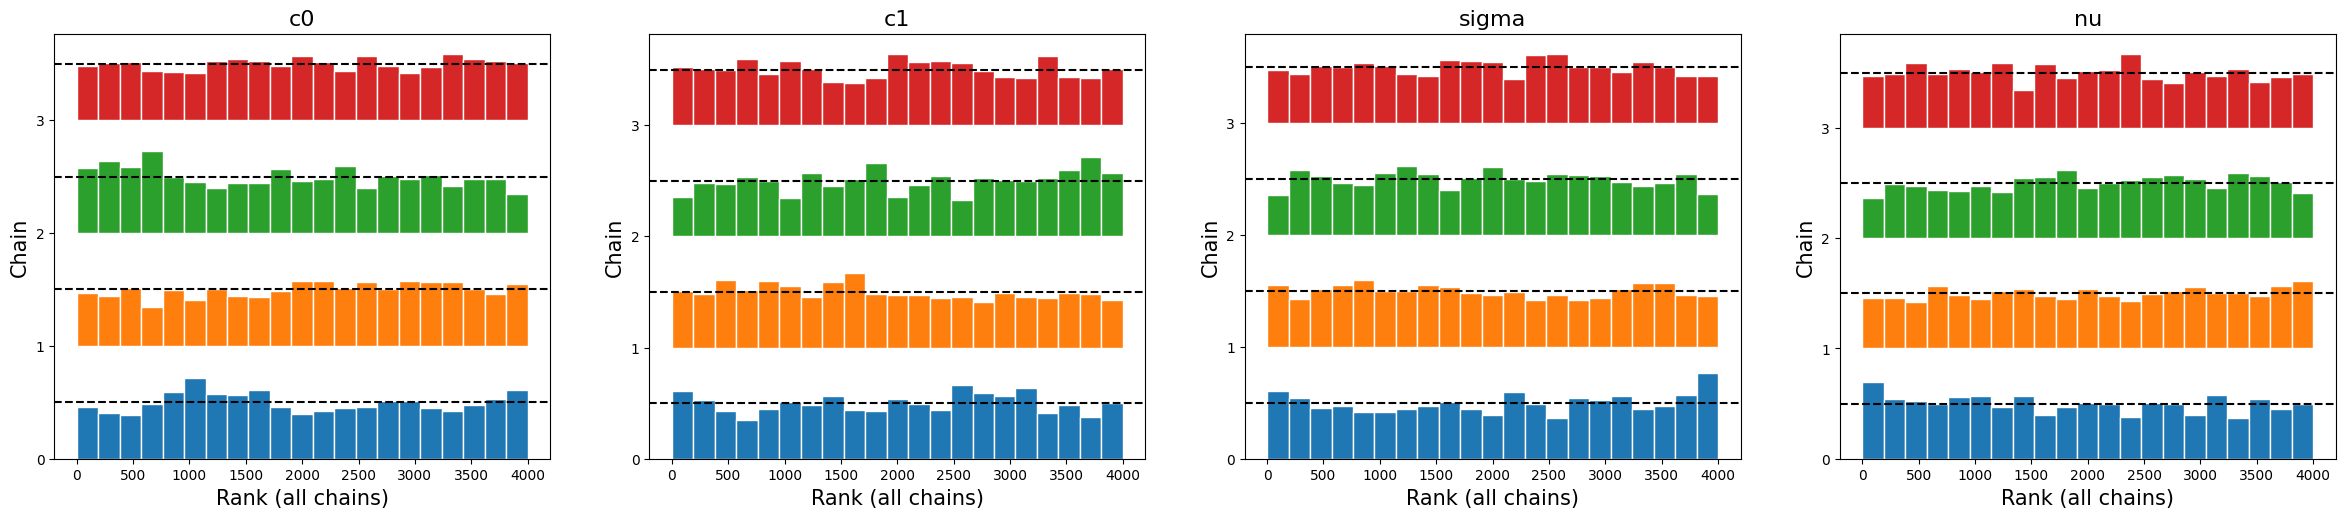

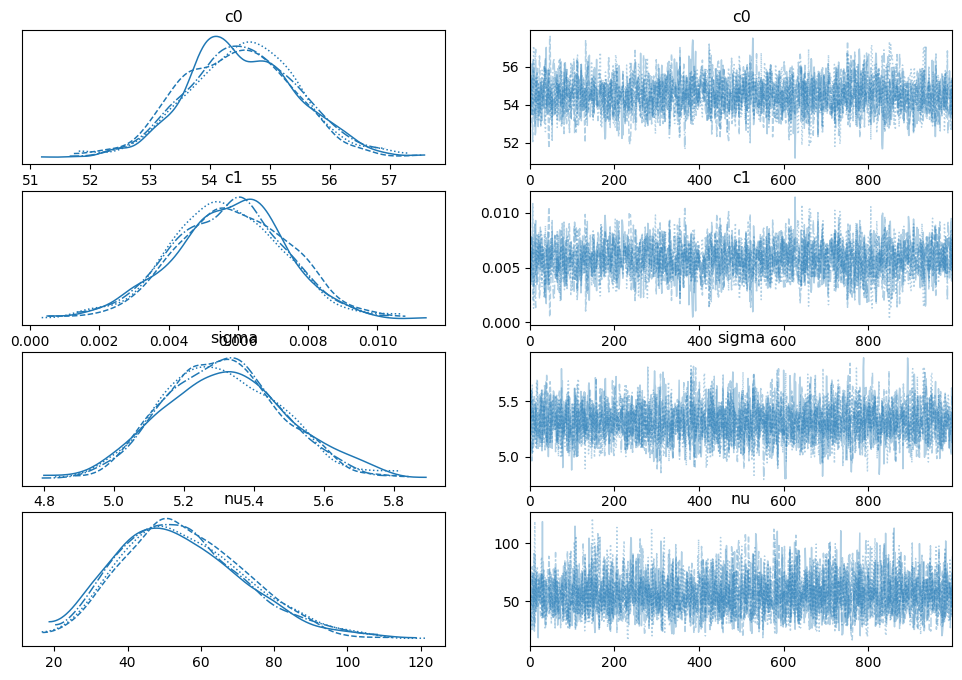

In [18]:
az.plot_rank(t_inference, var_names=['c0', 'c1', 'sigma', 'nu'])
az.plot_trace(t_inference, var_names=['c0', 'c1', 'sigma', 'nu'])
az.summary(t_inference, var_names=['c0', 'c1', 'sigma', 'nu'])

### Rank Plot and Inference Summary Analysis 

The goal of this analysis is to check if the sampler of the posterior distribution works correctly. \ 
We can evaluate the model's accuracy using the inference summary data. 

**r_hat** is equal to 1 for all estimated parameters. Therefore, the modeling results are reliable, the chains reached a stable distribution, and the results are not biased.

**ESS** is higher than for the previous model. More than half of the samples are independent of each other.

for c0 2088/4000 = 0.52 \
for c1 2087/4000 = 0.52 \
for sigma 2704/4000 = 0.68 \
for nu 2560/4000 = 0.64

**Rank plots** look more flat than the rank plot of the normal model. It means that chains reached a higher convergence.

We can also see the visualization of the convergence of the chins and the randomness of the sampling at the inference plots at the bottom. All values converged to the same distribution, and the chains mixed.

Based on the analysis above, the sampler works well, and the sampler for the t-distribution likelihood is slightly more efficient than the normal distribution likelihood.

### Credible Intervals  

In [19]:
with t_model:
    posterior_pred_t = pm.sample_posterior_predictive(t_inference)

Sampling: [likelihood]


In [20]:
predicted_mu_t = t_inference.posterior["mu"]
predicted_data_t = posterior_pred_t.posterior_predictive["likelihood"]

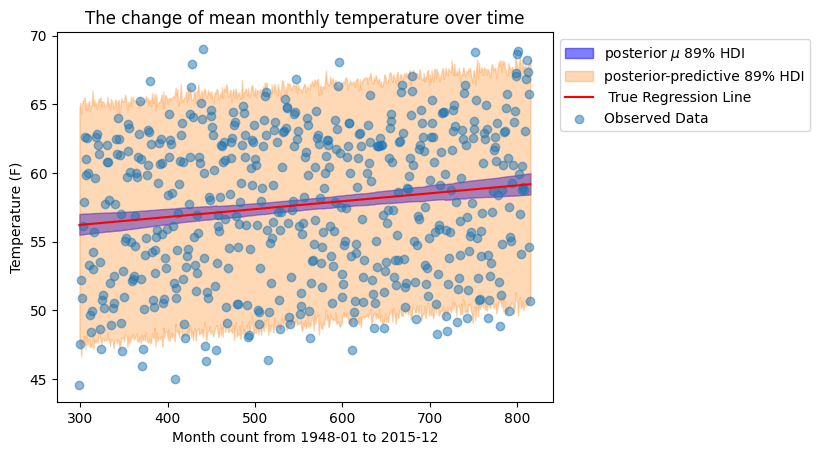

In [21]:
ax = az.plot_hdi(index, predicted_mu_t, color = 'b', smooth=False, hdi_prob=0.89, 
                fill_kwargs={'alpha': 0.5, 'label': 'posterior $\mu$ 89% HDI'}) #label 89% HDI for the true data 
az.plot_hdi(index, predicted_data_t, ax=ax, smooth=False, hdi_prob=0.89, 
           fill_kwargs={'alpha': 0.3, 'label': 'posterior-predictive 89% HDI'}) #89% HDI for the regression mean 

plt.plot(index, predicted_y, color='red', label=' True Regression Line')
plt.scatter(index, temperature, alpha=0.5, label='Observed Data')

plt.title('The change of mean monthly temperature over time')
plt.ylabel('Temperature (F)')
plt.xlabel('Month count from 1948-01 to 2015-12')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Credible Interval Analysis  

Similarly, as in the previous model, the purple-shaded area is 89% HDI of the regression mean, and the orange-shaded area is 89% HDI for posterior predictive distribution, representing possible outcomes for the data.

In this visualization, we also see a high accuracy of the model, which is determined by the following: \
a) posterior predictive distribution covering approximately 89% of the data points \
b) posterior being aligned with the true regression line

It is important to construct credible intervals to get a general picture of the model behavior and performance in terms of fitting the data. To check the predictive accuracy of the data, we will perform a PSIS test tater in the report.

Student's T distribution was supposed to be less sensitive to outliers. However, since we do not have heavy outliers, the results of this model highly resemble the results of the normal distribution likelihood model. I want to compare the fit of both normal and t likelihood models. 

### Credible Interval Overlap

Based on the figure below, we see barely any visual difference between the two models. The reason for that is the absence of heavy outliers that would show us how normal distribution gets more affected. There are still variations of the boundaries of the posterior predictive 89% HDI, which is expected given that two different models were used, and both had a degree of randomness.

Still, this tells us only the high similarity of the two models to fit the data, thus making the predictions about the data. They both have similarly high interpolation level. PSIS comparison will show us the difference in their predictive abilities (extrapolation). 

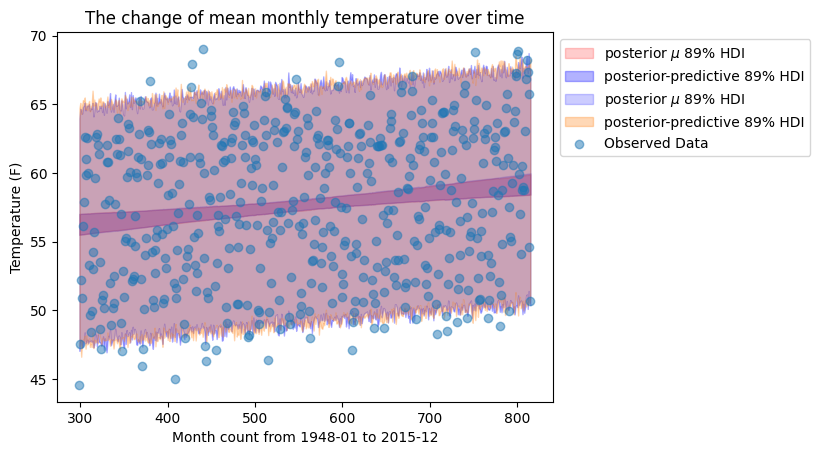

In [22]:
ax = az.plot_hdi(index, predicted_mu, color = 'r', smooth=False, hdi_prob=0.89, 
                fill_kwargs={'alpha': 0.2, 'label': 'posterior $\mu$ 89% HDI'})
az.plot_hdi(index, predicted_data, ax=ax, color = 'b', smooth=False, hdi_prob=0.89, 
            fill_kwargs={'alpha': 0.3, 'label': 'posterior-predictive 89% HDI'})

ax = az.plot_hdi(index, predicted_mu_t, color = 'b', smooth=False, hdi_prob=0.89, 
                fill_kwargs={'alpha': 0.2, 'label': 'posterior $\mu$ 89% HDI'}) #label 89% HDI for the true data 
az.plot_hdi(index, predicted_data_t, ax=ax, smooth=False, hdi_prob=0.89, 
           fill_kwargs={'alpha': 0.3, 'label': 'posterior-predictive 89% HDI'}) #89% HDI for the regression mean 


plt.scatter(index, temperature, alpha=0.5, label='Observed Data')
plt.title('The change of mean monthly temperature over time')
plt.ylabel('Temperature (F)')
plt.xlabel('Month count from 1948-01 to 2015-12')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Model 3 Outlier Detection Function

Function description: \
The outlier detection function has the exact core mechanism as the first model; the same Normal distribution is used with parameters mu and sigma. The mu parameter is defined in the same way as it was for the normal distribution. 

The main difference for this function is how the standard deviation is modeled. We have two standard deviation levels. The inner level contains the "inlier" data points, and we use the inner standard deviation (sigma in) to model it. The outer level contains "outlier" data points. We create the outer level model by adding the outlier-specific standard deviation to the inner level standard deviation (sigma in + sigma out).

By employing different standard deviations for inliers and outliers, the model accounts for the fact that regular data points (inliers) usually follow the expected pattern, while unusual data points (outliers) act differently and are more unpredictable.

**Inlier** standard deviation represents the typical variability of data points that conform to the general trend. The model considers inliers as representative of the regular data distribution. The inlier standard deviation is set to 4, which is just 1 point lower than the general standard deviation that was used for the two previous models. The reason for a relatively small decrease from the general standard deviation to the inlier standard deviation is that the data does not contain heavy outliers, and I expect most of the points to be outliers. Modified standard deviation helps us to narrow down the range for the inlier data points. Therefore, the inlier standard deviation is modeled using the help normal distribution with the parameter 4. 

**Outlier** level consists of the combination of the inlier standard deviation and the outlier standard deviation added to it. The model for the outlier standard deviation is also the half-normal distribution because we consider the probability of encountering points decreasing as we move away from the regression line. The standard deviation parameter is set to 30. This value reflects that outliers deviate significantly from the linear trend and have greater variability. We want to ensure that the model will capture all the potential outliers by setting a relatively large value. 

**p** represents the probability that a given data point is classified as an outlier. By changing it, we can adjust the model's sensitivity to outliers. A smaller p implies a higher threshold for a data point to be an outlier. A larger p makes the model more lenient in labeling data points as outliers, which is useful for a broader range of variations and a larger set of potential outliers. In our case, we do not expect to have many outliers, so we model the value of the parameter p as a uniform distribution with a range of values [0, 0.05]. It means that for every data point classification, there is an equal chance for any probability between 0 and 5% to be the parameter of the Bernoulli process of classifying the data point. 

The data point will be assigned to the inlier or outlier levels according to the outcome of the Bernoulli trial with parameter p. The outcome of the Bernoulli trial is a binary value. If the outcome is 1 *(P(x = 1) = p)*, the data point is classified as an outlier. If the outcome is 0 *(P(x = 0) = 1-p)*, the data point is considered an inlier. According to this classification, different standard deviations apply. 

\begin{align*}
\text{Likelihood:} \\
y_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= c_0 + c_1x_i \\
\text{Outlier Assignment:} \\
\sigma_i\ &= \begin{cases} 
\sigma_{in} & \text{if } q_i = 0 \\
\sigma_{in} + \sigma_{out} & \text{if } q_i = 1
\end{cases} \\
q_i &\sim \text{Bernoulli}(p) \\ \\
\text{Prior:} \\
c_0 &\sim \text{Uniform}(0, 100) \\
c_1 &\sim \text{Normal}(0, 5^2) \\
\sigma_{in} &\sim \text{Half-Normal}(4^2) \\
\sigma_{out} &\sim \text{Half-Normal}(30^2) \\
p &\sim \text{Uniform}(0, 0.05)
\end{align*}

In the code, standard deviation is used, while the mathematical notation commonly represents variance, the square of standard deviation. To align these notations, the square of the discussed standard deviation is computed, converting the standard deviation to its variance.

In [23]:
#this code is adapted from the class session 7.1 

with pm.Model() as outlier_model:
    #Data
    x = pm.MutableData('x', index)
    y = pm.MutableData('y', temperature)
    
    #Prior
    c0 = pm.Uniform('c0', lower=0, upper=100)
    c1 = pm.Normal('c1', mu=0, sigma=4)
    mu = pm.Deterministic('mu', c0 + c1 * x)
    
    # Noise parameters for inliers and outliers
    sigma = pm.HalfNormal('sigma', sigma=5)
    sigma_out = pm.HalfNormal('sigma_out', sigma=30)
    sigmas = pt.as_tensor_variable([sigma, sigma + sigma_out])

    # In/out class assignment probability and indicators
    p = pm.Uniform('p', lower=0, upper=0.05)
    q = pm.Bernoulli('q', p=p, size=x.shape[0])
    
    #Likelihood 
    pm.Normal('likelihood', mu=mu, sigma=sigmas[q], observed=y)
    
    #sample 
    outlier_inference = pm.sample(target_accept = 0.99)
    
    #compute log likelihood 
    pm.compute_log_likelihood(outlier_inference)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [q]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Rank Plot and Inference Summary 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,54.525,0.907,52.882,56.228,0.026,0.019,1170.0,1695.0,1.00
c1,0.006,0.002,0.003,0.009,0.000,0.000,1218.0,1613.0,1.00
sigma,5.345,0.168,5.025,5.655,0.004,0.003,2062.0,1907.0,1.00
sigma_out,10.581,14.516,0.004,39.437,0.731,0.518,102.0,1011.0,1.05
p,0.014,0.014,0.000,0.043,0.002,0.001,95.0,614.0,1.06


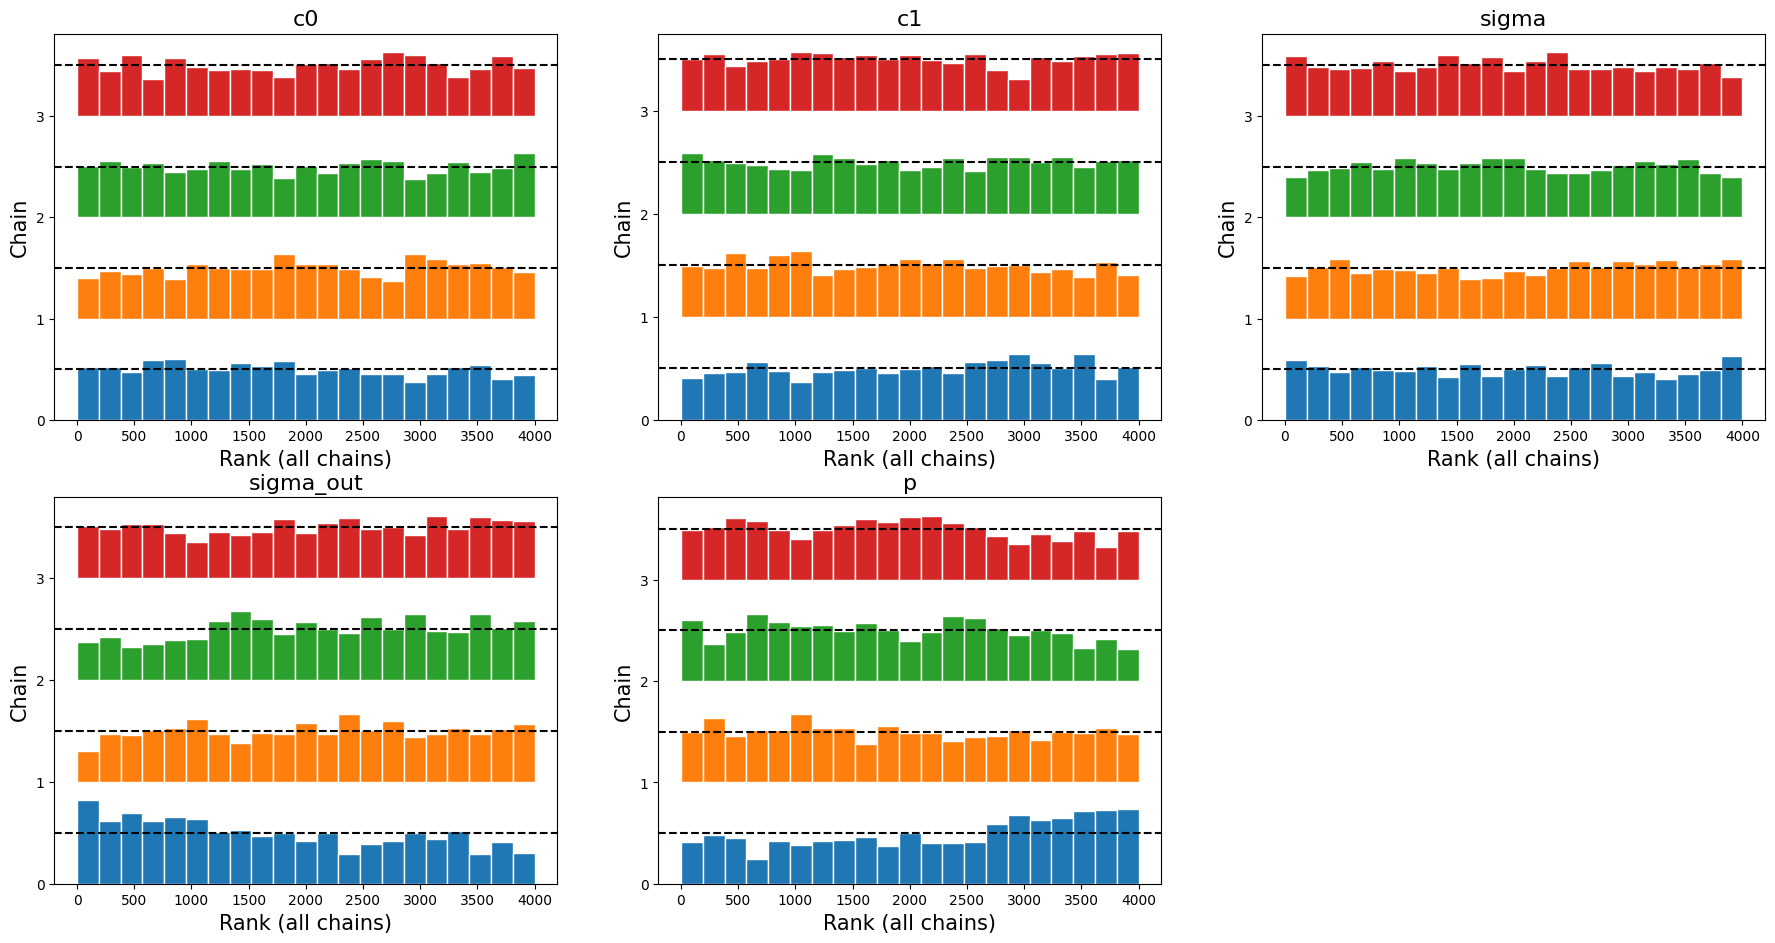

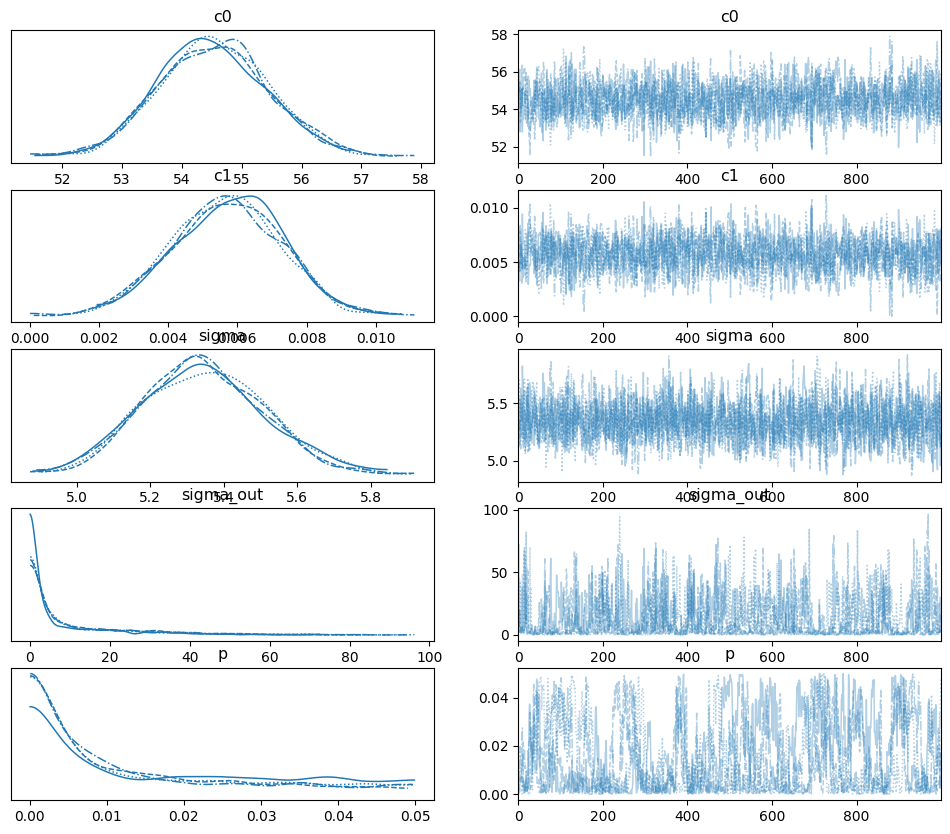

In [24]:
az.plot_rank(outlier_inference, var_names = ['c0', 'c1', 'sigma', 'sigma_out', 'p'])
az.plot_trace(outlier_inference, var_names = ['c0', 'c1', 'sigma', 'sigma_out', 'p'])
az.summary(outlier_inference, var_names = ['c0', 'c1', 'sigma', 'sigma_out', 'p'])

### Rank Plot and Inference Summary Analysis

Rank Plots, Inference Plots, and Inference summary will be used to analyze how well the sampler works.
Based on the inference summary, we can see that the sampler worked better for the parameters c0, c1, and sigma and worse for sigma_out and p. 

**r_hat** the value 1 for this metric would mean a good convergence. Generally, it is close to 1 for all parameters but slightly larger than 1 for sigma_out and p, 1.01 and 1.03, respectively. It is not a big deviation, but it is still worth noticing because we can see that the other metrics follow a similar pattern. 

**ESS** This metric tells us the number of independent samples, which is important for the model's reliability. We can see a pattern that for all parameters, there are more independent samples at the tail of the distribution and less in the center. As a rule of thumb, we expect at least 10% of the samples to be independent. 

c0	        994/4000 = 0.248	\
c1	        1059/4000 = 0.264	\
sigma	    1801/4000 = 0.45	\
sigma_out	388/4000 = 	0.097   \
p           263/4000 = 0.065

Again, the outer layer standard deviation and p have less than 10% of the independent samples. This means that the model is not effectively exploring the parameter space, the chain may not have mixed well, and the samples may be autocorrelated.

Based on the **rank plot**, we see the other evidence for it. The sample distribution for sigma_out and p is less normal than that of c0, c1, and sigma. 

Based on the visual examination of the posterior distribution chains, we see that they all mix and converge to the same distribution, although the alignment is imperfect. We can see the visualization of the sampling process. The sampling is random for c0, c1, and sigma, and we see that for sigma_out and p, the probability of getting a lower value is higher. So, the number of outliers will be lower than we analytically expected. 

When there are few or no outliers to model, the uncertainty and variability associated with these parameters may not be accurately captured. It might be explained by the fact that there were barely any outliers in the data we passed in the likelihood function. Therefore, the model might not have enough data to capture the uncertainty and variability associated with the parameters responsible for the outliers.

Another reason for the sampling problem can be not enough samples. I addressed this by increasing the sample size. I set draws to 5,000, so I got 20,000 samples instead of 4000. Based on the visual examination of the graphs, the ess statistics did not change the situation. Ess for sigma_out was 6%, and for p, it was 4%. Therefore, the problem was in the low level of outliers in the data rather than in the insufficient number of samples. 


### Credible Interval 

In [25]:
with outlier_model:
    posterior_pred_o = pm.sample_posterior_predictive(outlier_inference, extend_inferencedata=True)

Sampling: [likelihood]


In [26]:
predicted_mu_o = outlier_inference.posterior.mu.median(dim=['chain', 'draw']).values
predicted_data_o = posterior_pred_o.posterior_predictive["likelihood"]

/Users/tetianabas/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


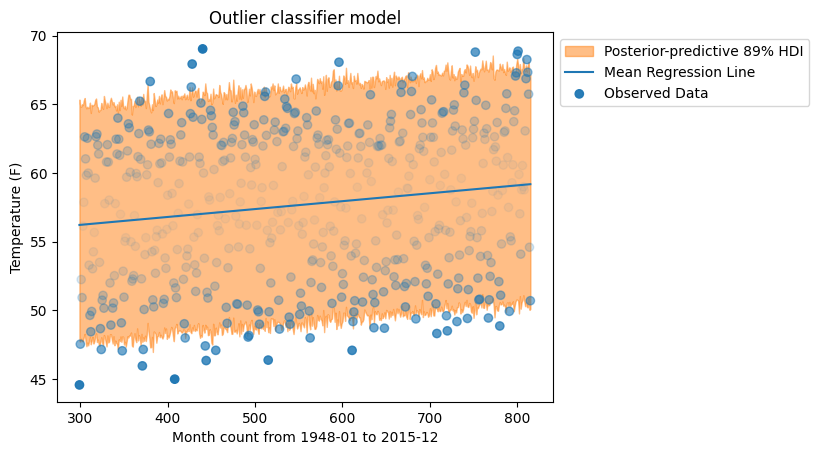

In [27]:
az.plot_hdi(index, predicted_data_o, hdi_prob=0.89, smooth=False, 
           fill_kwargs={'alpha': 0.5, 'label': 'Posterior-predictive 89% HDI'})
plt.plot(index, predicted_mu_o, label='Mean Regression Line')
weights = az.loo(outlier_inference, pointwise=True).loo_i.values
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())

plt.scatter(index, temperature, alpha=alpha, color='C0', label='Observed Data')
plt.title('Outlier classifier model')
plt.ylabel('Temperature (F)')
plt.xlabel('Month count from 1948-01 to 2015-12')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Credible Interval Analysis 

The figure above shows 89% credible intervals (high-density intervals (HDI) for the posterior predictive data of the outlier classification model.  

This credible interval differs from the previous two because LOO weights on the data were computed. LOO means "Leave-One-Out." This measure is computed on each data point from the observed data. It reflects the influence of each data point on the model. So, the higher the weight of the data point, the more it deviates from the trend. We can also see that the data points have different transparency levels. Transparency is changed based on the LOO weights, with darker points indicating higher weights. This transparency visually indicates which data points are more influential in evaluating the model.

Based on the LOO weights assignment, we see that data points closer to the regression were identified as inliers, and those further from the regression line were recognized as potential outliers. It aligns with the primary use case of the model: differentiate the values that deviate from the trend. While we don't have extreme outliers in this dataset, the fact that the model can recognize and assign higher weights to data points with higher deviations is an indicator of the model's sensitivity. In other scenarios with more distinctive outliers, this model has the potential to identify and classify outliers effectively.

The model captured most of the true data points in the credible interval of the posterior-predictive distribution. Approximately 10% of the data points are beyond the interval, which aligns with the assumptions. 

# Part 3: Model comparison 

I will use PSIS leave-one-out cross-validation to compare the models and quantify the best model.

PSIS leave-one-out cross-validation is used to evaluate the out-of-sample accuracy of the models. In most cases, when we are building the model, our goal is to use it for future data prediction, so we are interested in extrapolation more than in interpolation accuracy. 

Cross-validation tests the model's predictive accuracy on another sample. We divide the sample into several chunks, called "folds." and predict each fold based on all the others. If we use the maximum number of folds, we leave out one unique observation in each fold. This is called leave-one-out cross-validation (LOO CV).

Leave-One-Out Cross-Validation estimates the Logarithm Pointwise Predictive Density (LPPD). It consists of removing one data point at a time and calculating the probability density of that isolated data point based on the model's predictions using the remaining data. The resulting value is called Pointwise Predictive Density (PPD). To simplify the computation and interpretation, we take the logarithm of that value. We add all of the values of the LPPD. LPPD considers the model's uncertainty by integrating over all possible values of the model's parameters. This reflects the overall predictive performance of the model, considering its parameter uncertainty.

PSIS stands for Pareto-smoothed Importance Sampling. The idea behind it is that not all observations are equally important. A relatively unlikely observation is more important than one that is relatively expected. We use Pareto distribution to model the weights of the importance of individual data points. The smoothing part of PSIS stabilizes these weights, making them more reliable and robust. 



In [28]:
inferences = {'Normal': normal_inference, 'Student-T': t_inference, 'Outlier': outlier_inference}
df = az.compare(inferences, ic='loo')
df

/Users/tetianabas/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Normal,0,-1586.843706,2.487465,0.000000,1.000000e+00,10.959010,0.000000,False,log
Outlier,1,-1587.367094,2.985771,0.523388,4.107825e-15,10.953183,0.027717,True,log
Student-T,2,-1589.658508,2.571869,2.814801,0.000000e+00,11.007001,0.165172,False,log


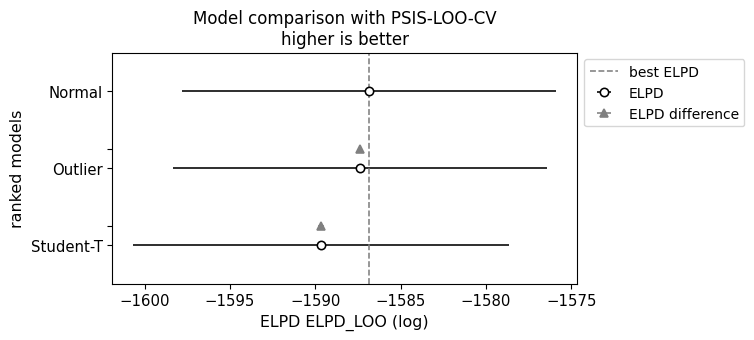

In [29]:
#this code is adapted from the class session 7.1 

az.plot_compare(df)
plt.title('Model comparison with PSIS-LOO-CV\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD',  'ELPD', 'ELPD difference'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Analysis of  PSIS LOO CV

The figure above demonstrates the results for the three models that we created. We use PSIS LOO CV to see how the model fits the "new" data points and compute ELPD (average of individual LPPD) on those data points. The x-axis represents the ELPD values. The y-axis represents the ranking of the model. The model with the lowest ELPD is ranked 1, and others are ranked accordingly. A lower rank (higher position on the graph) indicates a better-performing model.

The vertical dashed line shows us how the best model performs relative to other models. Empty dots show the ELPD value for each model. The analysis results show that the normal likelihood model had the best predictive accuracy, while Studet-T had the lowest predictive accuracy. Despite having aligned credible intervals for the posterior distribution value, their predictive accuracy differs. ELPD difference between the best-performing normal model and the student's T model is 2.75. Still, the difference is insignificant given that the ELPD value for the normal model is -1586.

The dataset had relatively few outliers and followed a relatively well-behaved, near-normal distribution. Therefore, the Normal likelihood model is the best fit. 

Since there were few outliers, the robustness offered by the Student-T model did not provide a significant advantage. Similarly, the Outlier model, designed to handle deviations from the pattern, could have been less effective when there were few outliers to capture. Additionally, the extra parameters in the complex outlier detection model might have led to overfitting since they were not necessary. Overfitting might have reduced predictive performance of the outlier model.


# AI statement 

AI tools were used for this assignment to help debug the code (GPT) and check grammar (Grammarly). I also used chat GPT to give me feedback on interpretation or explain things that I did not understand instead of googling it (both during the assignment and in general during the class preparation)

# References

NCEI.Monitoring.Info@noaa.gov. (n.d.). Global Time Series | Climate at a Glance | National Centers for Environmental Information (NCEI). https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/land_ocean/ann/12/1880-2019


San Francisco Weather: Why is it so cold?!! (n.d.). Fog City Secrets. https://www.inside-guide-to-san-francisco-tourism.com/san-francisco-weather.html

Zonination. (n.d.). weather-us/sanfrancisco.csv at master · zonination/weather-us. GitHub. https://github.com/zonination/weather-us/blob/master/sanfrancisco.csv

Local weather forecast, news and conditions | Weather Underground. (n.d.). https://www.wunderground.com/
